### Modeling and visualizing dynamics of COVID cases in Maryland counties
#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-03-28


In [3]:
# import latest MD county counts
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_county_covid.csv'
md_county=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)

In [4]:
# create exponential function to model 
# will add additional functions shortly

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    return a*x + b

In [5]:
def SSE_curve(x,y,fxn):
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

In [6]:
# date range of the graph
start_date = min(md_county['Date'])
end_date = max(md_county['Date'])
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-05 to 2020-03-27


In [7]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)


# output date range as list
dates = [date.strftime('%m/%d') for date in date_range_plus]

In [8]:
# exponential fit for select counties
counties_to_model=['Montgomery','Anne Arundel',"Prince Georges","Howard",'Baltimore City','Baltimore County','Total']
model_results=pd.DataFrame(index=counties_to_model,columns=['a','b','c','model'])
model_results.fillna(0)

xdata=np.array(md_county.index)[-10:]
for county in counties_to_model:
    ydata=np.array(md_county[county])[-10:]
    
    popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    min_error=min(SSE_exp,SSE_quad,SSE_lin)
    
    if min_error == SSE_exp:
        model_results.loc[county,['a','b','c']]=popt_exp
        model_results.loc[county,'model']='exp'
    elif min_error == SSE_quad:
        model_results.loc[county,['a','b','c']]=popt_quad
        model_results.loc[county,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'

In [9]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates)))
xdata_pred=np.array(range(len(dates)))[-11:]

In [10]:
#func use
def function_use(county,model_results):
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'quadratic'
    else:
        func_use=lin_func
        opt_model = 'linear'
    return func_use, opt_model

### Maryland model and dynamics

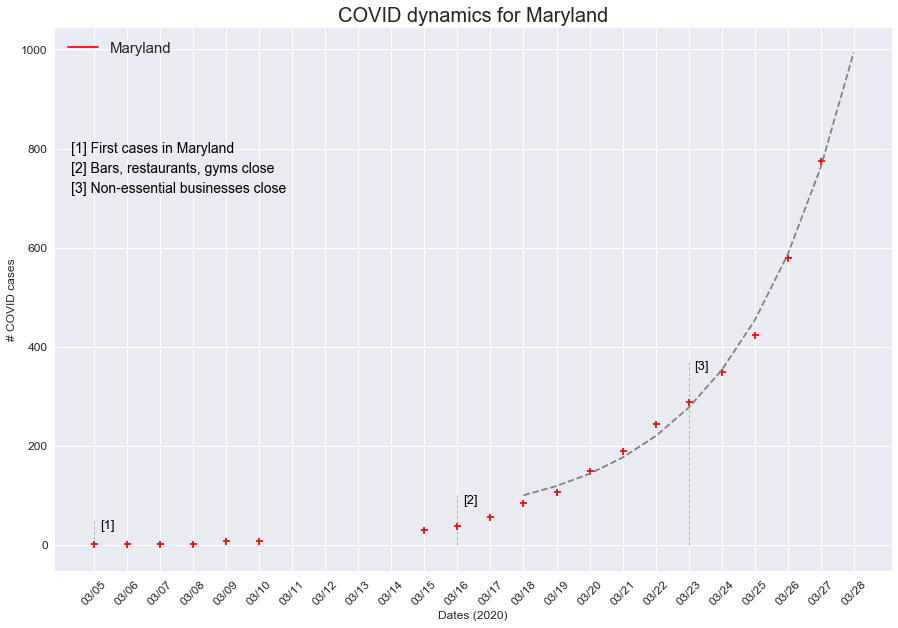

In [23]:
legend_elements =  [Line2D([0], [0], marker='+', color='red', label='Maryland', markersize=15)]

popt_state = model_results.loc["Total"][0:3]

func_use, opt_model = function_use("Total",model_results)

plt.figure(figsize=(15,10))

plt.plot(xdata_pred, func_use(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(md_county.index,md_county['Total'],color='red',marker='+');

plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,40,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=100,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,90,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=370,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,360,"[3]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');


plt.text(-0.7,800,"[1] First cases in Maryland",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,760,"[2] Bars, restaurants, gyms close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,720,"[3] Non-essential businesses close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');

plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=12)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.title("COVID dynamics for Maryland",fontsize=20);
   

In [27]:
# Predict next day's cases
next_day = xdata_pred[-1]
next_day_cases = func_use(next_day, popt_state[0], popt_state[1], popt_state[2])
print(f"The best model for Maryland is the {opt_model} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_cases)}.")

The best model for Maryland is the exponential model.  Prediction for number of total cases for 03/28 is 993.


### Dynamics for two counties: Montgomery and Prince George's

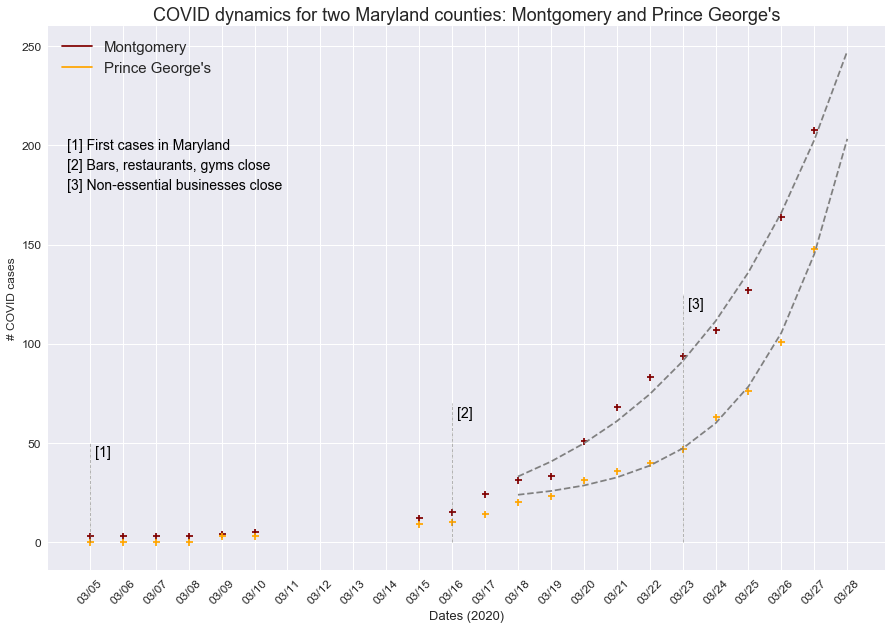

In [28]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label='Montgomery', markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label="Prince George's", markersize=15)]

poptM = popt_state = model_results.loc["Montgomery"][0:3]
poptP = popt_state = model_results.loc["Prince Georges"][0:3]

func_useM, opt_modelM = function_use("Montgomery",model_results)
func_useP, opt_modelP = function_use("Prince Georges",model_results)

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useM(xdata_pred, *poptM), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Montgomery'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useP(xdata_pred, *poptP), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Prince Georges'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,45,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=70,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,65,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=125,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,120,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.text(-0.7,200,"[1] First cases in Maryland",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,190,"[2] Bars, restaurants, gyms close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,180,"[3] Non-essential businesses close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');


plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=13)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.title("COVID dynamics for two Maryland counties: Montgomery and Prince George's",fontsize=18);   

In [29]:
# Predict next day's cases
next_day_casesM = func_useM(next_day, poptM[0], poptM[1], poptM[2])
next_day_casesP = func_useP(next_day, poptP[0], poptP[1], poptP[2])
print(f"The best model for Montgomery is the {opt_modelM} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_casesM)}.")
print(f"The best model for Prince Georges is the {opt_modelP} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_casesP)}.")

The best model for Montgomery is the exponential model.  Prediction for number of total cases for 03/28 is 247.
The best model for Prince Georges is the exponential model.  Prediction for number of total cases for 03/28 is 203.


### Dynamics for two counties: Howard and Anne Arundel

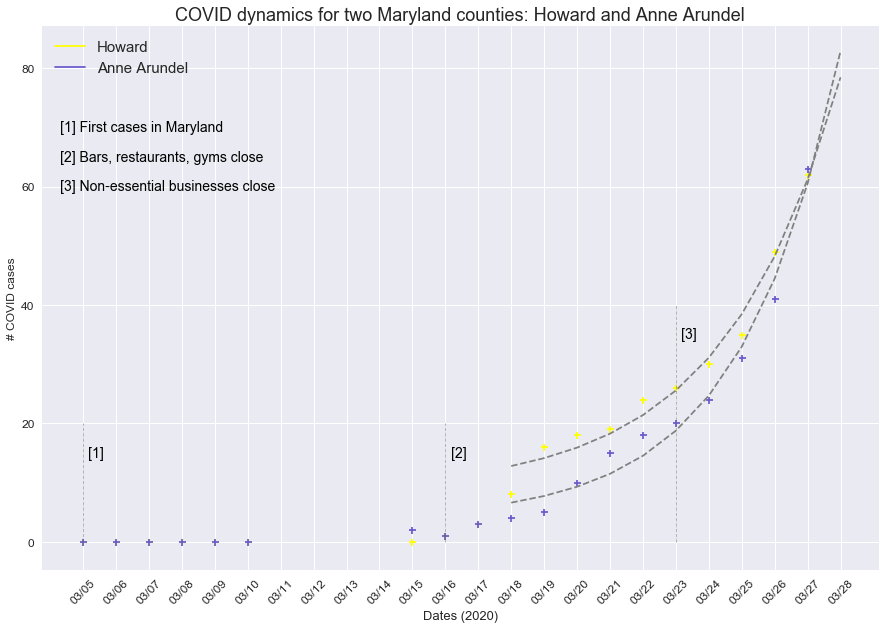

In [15]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='yellow', label='Howard', markersize=15),
                    Line2D([0], [0], marker='+', color='slateblue', label="Anne Arundel", markersize=15)]

poptH = popt_state = model_results.loc["Howard"][0:3]
poptA = popt_state = model_results.loc["Anne Arundel"][0:3]

func_useH, opt_modelH = function_use("Howard",model_results)
func_useA, opt_modelA = function_use("Anne Arundel",model_results)

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useH(xdata_pred, *poptH), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Howard'],color='yellow',marker='+')

plt.plot(xdata_pred, func_useA(xdata_pred, *poptA), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Anne Arundel'],color='slateblue',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,15,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,15,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=40,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,35,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.text(-0.7,70,"[1] First cases in Maryland",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,65,"[2] Bars, restaurants, gyms close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,60,"[3] Non-essential businesses close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');


plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=13)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.title("COVID dynamics for two Maryland counties: Howard and Anne Arundel",fontsize=18);   

In [16]:
# Predict next day's cases
next_day_casesH = func_useH(next_day, poptH[0], poptH[1], poptH[2])
next_day_casesA = func_useA(next_day, poptA[0], poptA[1], poptA[2])
print(f"The best model for Howard is the {opt_modelH} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_casesH)}.")
print(f"The best model for Anne Arundel is the {opt_modelA} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_casesA)}.")

The best model for Howard is the exponential model.  Prediction for number of total cases for 03/28 is 101.
The best model for Anne Arundel is the exponential model.  Prediction for number of total cases for 03/28 is 114.


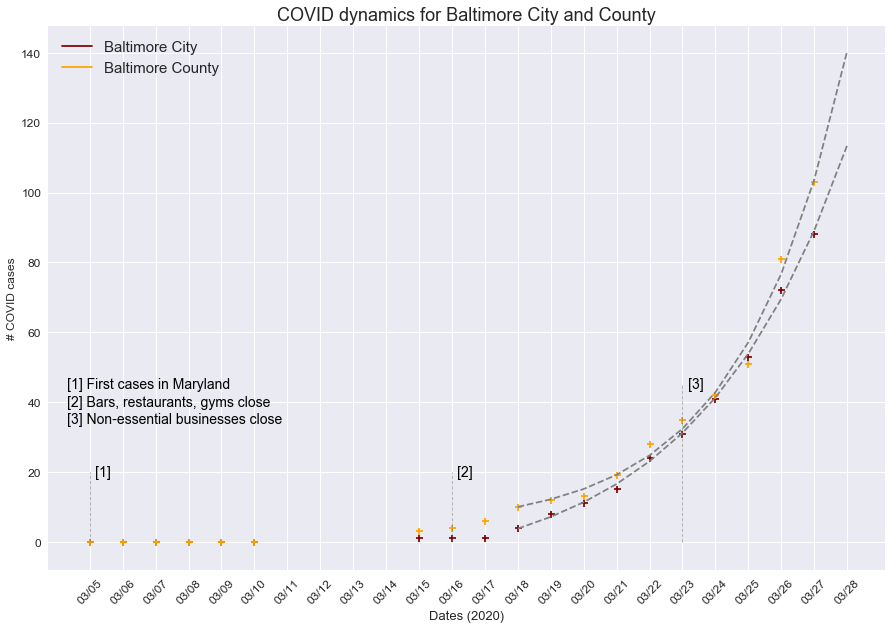

In [17]:
# BALTIMORE
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label='Baltimore City', markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label="Baltimore County", markersize=15)]

poptB1 = popt_state = model_results.loc["Baltimore City"][0:3]
poptB2 = popt_state = model_results.loc["Baltimore County"][0:3]

func_useB1, opt_modelB1 = function_use("Baltimore City",model_results)
func_useB2, opt_modelB2 = function_use("Baltimore County",model_results)

plt.figure(figsize=(15,10));

# Plot data + model
# model

plt.plot(xdata_pred, func_useB1(xdata_pred, *poptB1), color='grey',linestyle='--')
# data
plt.scatter(md_county.index,md_county['Baltimore City'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useB2(xdata_pred, *poptB2), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Baltimore County'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,20,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,20,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=45,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,45,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.text(-0.7,45,"[1] First cases in Maryland",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,40,"[2] Bars, restaurants, gyms close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');
plt.text(-0.7,35,"[3] Non-essential businesses close",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='left');

plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=13)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.title("COVID dynamics for Baltimore City and County",fontsize=18)   ; 


In [18]:
# Predict next day's cases
next_day_casesB1 = func_useB1(next_day, poptB1[0], poptB1[1], poptB1[2])
next_day_casesB2 = func_useB2(next_day, poptB2[0], poptB2[1], poptB2[2])
print(f"The best model for Baltimore City is the {opt_modelB1} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_casesB1)}.")
print(f"The best model for Baltimore County is the {opt_modelB2} model.  Prediction for number of total cases for {tomorrow_label} is {int(next_day_casesB2)}.")

The best model for Baltimore City is the exponential model.  Prediction for number of total cases for 03/28 is 143.
The best model for Baltimore County is the exponential model.  Prediction for number of total cases for 03/28 is 190.
